In [1]:
trainingOHCA_fileName = "generatedPoints1_100000_area.csv"
candidateAED_fileName = "buildings_locations_area.csv"
# trainingOHCA_fileName = "generatedPoints1_100000_subzone.csv"
# candidateAED_fileName = "buildings_locations_subzone.csv"
testOHCA_fileName = "generatedPoints2_15000.csv"
currentAED_fileName = "AED Details_As of 27 March 2019 (2).xlsx"

In [2]:
import pandas as pd
import numpy as np
from haversine import haversine_vector, Unit
from haversine import haversine
from os import path
import scipy.sparse
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
from pulp import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt     
import seaborn as sns
from itertools import combinations
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score
import scipy
import scipy.cluster
from matplotlib import colors as mcolors
from skimage.io import imread
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
import time

In [3]:
def PCM2(OHCA_Cluster,AED_Cluster,pij,P):
    J = OHCA_Cluster.index.values.tolist()
    I = AED_Cluster.index.values.tolist()
    
    #Decision Variables + Maximization
    
    prob = LpProblem("PCM",LpMaximize)
    w = LpVariable.dicts("w",(I,J),0,1,cat = "Integer")
    y = LpVariable.dicts("y",I,0,1,cat="Integer")
    
    #objective
    
    prob += lpSum([pij[j][i]*w[i][j] for i in I for j in J if pij[j][i] > 0])
    
    #constraints
    
    for j in J:
        for i in I:
            if (pij[j][i] > 0):
                prob += w[i][j] <= y[i]
    for j in J:
        prob += lpSum([w[i][j] for i in I if pij[j][i] > 0]) <= 1
    
    prob += lpSum([y[i] for i in I]) <= P
    prob.solve(GUROBI(msg=0))
    y_soln = np.array([y[i].varValue for i in I])
    print("Coverage is ",value(prob.objective))
    AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(y_soln,columns=['y'])],axis=1)
    AED_Chosen = AED_Chosen[AED_Chosen['y'] == 1]
    AED_Chosen = AED_Chosen.drop(columns=['y'])
    return(AED_Chosen)

In [4]:
def kmeans_OHCA_AED(OHCA,AED,k=2): #k is the number of clusters chosen
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(OHCA)
    
    OHCA_Cluster_All = pd.concat([OHCA,pd.DataFrame(kmeans.labels_,columns = ["cluster"])],axis=1)
    AED_lable = kmeans.predict(AED)
#     print(len(AED_lable))
    AED_Cluster_All = pd.concat([AED, pd.DataFrame(AED_lable,columns = ["cluster"])], axis=1)

    return OHCA_Cluster_All, AED_Cluster_All

In [5]:
def coveragefunction(OHCA_Cluster,AED_Cluster):
    pij = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    pij = [[1 if p <= 20 else p for p in s] for s in pij]
    pij = [[np.exp(-0.05*(p - 20)) if p > 20 and p <= 100 else p for p in s] for s in pij]
    pij = [[0 if p>100 else p for p in s] for s in pij]
    return(pij)

In [6]:
def haverDist(OHCA_Cluster,AED_Cluster):
    d = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    return(d)

In [7]:
#test_OHCA = pd.read_csv(testOHCA_fileName, names = ["LatOHCA", "LongOHCA"], header = None)
OHCA = pd.read_csv(trainingOHCA_fileName)
candidateAED = pd.read_csv(candidateAED_fileName)
# candidateAED.columns = ["LatAED","LongAED"]
P_count=OHCA['region'].value_counts()
print(len(P_count.values))
print(P_count.values.sum())
P_count

53
97541


20    7528
32    5115
1     4588
8     4285
10    3835
50    3555
28    3509
19    3318
55    3305
54    3258
11    3245
24    3104
35    2906
23    2794
9     2791
27    2705
16    2377
53    2129
15    2113
4     1960
21    1947
3     1932
7     1796
13    1793
51    1686
33    1632
26    1616
2     1586
6     1476
37    1343
31    1325
49    1227
18    1198
34    1190
5     1123
29     642
45     621
41     583
43     529
25     509
44     505
22     394
46     365
17     312
40     301
42     264
36     260
30     254
38     234
39     210
47     162
12      97
52       9
Name: region, dtype: int64

In [8]:
P_count2=candidateAED['region'].value_counts()
print(P_count2)

20    16891
3     12626
28    12328
8      8444
50     7772
19     5940
15     4684
49     4590
21     4186
11     4115
16     3557
45     3500
32     3406
35     3387
24     3315
10     3062
43     3057
55     3055
7      2885
23     2736
33     2715
26     2615
1      2218
54     2092
27     1938
2      1880
6      1692
36     1614
18     1190
44     1074
31      998
9       983
46      954
37      939
17      868
41      732
30      633
53      597
5       545
13      325
42      324
25      295
22      287
40      219
52      171
12      155
51      133
14       35
4        20
39       18
47        9
38        6
48        4
34        4
29        3
Name: region, dtype: int64


In [37]:
# P_count.at[159]

In [52]:
for subzone in range(1,333):
#     if subzone != 7 and subzone!=14 and subzone != 48 : 
#     if subzone not in (7, 8, 9,159,304):
    if subzone not in (7, 8, 9,159,174,231, 239,283, 284, 287,301, 304, 305, 317, 323):
#         p_subzone=int(P_count.at[subzone]*9800/96228)
        print(subzone, P_count2.at[subzone] )

1 6
2 179
3 100
4 167
5 78
6 3
10 604
11 38
12 83
13 8
14 263
15 113
16 45
17 313
18 45
19 27
20 75
21 58
22 162
23 747
24 60
25 70
26 88
27 68
28 2856
29 12
30 91
31 106
32 315
33 26
34 127
35 20
36 18
37 81
38 789
39 71
40 95
41 215
42 146
43 65
44 630
45 43
46 115
47 31
48 93
49 37
50 75
51 283
52 140
53 57
54 198
55 480
56 412
57 191
58 28
59 52
60 218
61 105
62 144
63 99
64 124
65 2531
66 142
67 10
68 1381
69 93
70 63
71 62
72 428
73 153
74 211
75 150
76 135
77 79
78 252
79 200
80 25
81 13
82 253
83 292
84 136
85 157
86 720
87 864
88 121
89 198
90 7
91 32
92 176
93 46
94 299
95 292
96 293
97 31
98 131
99 1510
100 2840
101 1138
102 386
103 878
104 48
105 1887
106 215
107 75
108 1609
109 391
110 1478
111 136
112 331
113 77
114 78
115 334
116 11
117 460
118 70
119 84
120 58
121 45
122 62
123 1618
124 113
125 233
126 89
127 436
128 885
129 242
130 129
131 1110
132 363
133 940
134 625
135 217
136 89
137 289
138 575
139 1047
140 53
141 7122
142 153
143 1884
144 2663
145 112
146 157
147 

In [9]:
# input: two clusters 
# output: All_AED_in_Cluster
def PCM_in_Cluster(OHCA1,candidateAED1,p_subzone,k=3):
    OHCA1_clusters, candidateAED1_clusters = kmeans_OHCA_AED(OHCA1, candidateAED1,k)
    All_AED_in_Cluster=pd.DataFrame(columns=['LatAED', 'LongAED']) 
    for i in range(k):
        OHCA20a = OHCA1_clusters[OHCA1_clusters['cluster']==i][["LatOHCA","LongOHCA"]].reset_index(drop=True)
        candidateAED20a = candidateAED1_clusters[candidateAED1_clusters['cluster']==i][["LatAED","LongAED"]].reset_index(drop=True)
        if len(OHCA20a)>0 and len(candidateAED20a)>0:
                prob_pij = coveragefunction(OHCA20a,candidateAED20a)
                sub_AED_df = PCM2(OHCA20a,candidateAED20a,prob_pij,int(p_subzone/k))
                All_AED_in_Cluster=All_AED_in_Cluster.append(sub_AED_df)
        else: pass
    return All_AED_in_Cluster

In [13]:
%%time

start_time = time.time()

ALL_AED= pd.DataFrame(columns=['LatAED', 'LongAED']) 
all_AED_num=9800
all_OHCA_num=97541

for subzone in range(1,56):
    if subzone!=14 and subzone != 48 : 
#       if subzone== 24 or subzone== 8:
        p_subzone=int(P_count.at[subzone]*all_AED_num/all_OHCA_num)
        print(subzone, P_count.at[subzone], p_subzone )
        OHCA1=OHCA[OHCA['region']== subzone]
        OHCA1=OHCA1[['LatOHCA','LongOHCA']].reset_index(drop=True)
        candidateAED1 = candidateAED[candidateAED['region']==subzone].copy()
        candidateAED1 = candidateAED1[['LatAED','LongAED']].reset_index(drop=True)
        candidateAED1 = candidateAED1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
        AED_sub =PCM_in_Cluster(OHCA1,candidateAED1,p_subzone,3)
        ALL_AED=ALL_AED.append(AED_sub)
print("--- %s seconds ---" % (time.time() - start_time))

1 4588 460
Coverage is  385.87110100451497
Coverage is  523.2345550562341
Coverage is  249.37172209469105
2 1586 159
Coverage is  38.85093771514173
Coverage is  171.08193494509015
Coverage is  140.78483895023547
3 1932 194
Coverage is  148.09840329493176
Coverage is  152.46807233616076
Coverage is  151.1853518979744
4 1960 196
Coverage is  3.1485424642191306
Coverage is  1.7736207204010073
Coverage is  0.0
5 1123 112
Coverage is  1.9255940122044466
Coverage is  61.33297295365082
Coverage is  11.18651354587686
6 1476 148
Coverage is  108.88845751611507
Coverage is  136.66051693838136
Coverage is  120.03010973156447
7 1796 180
Coverage is  164.7532903278532
Coverage is  77.0972142897434
Coverage is  144.96221910670505
8 4285 430
Coverage is  349.77017978443007
Coverage is  549.7362753616653
Coverage is  412.13780253908243
9 2791 280
Coverage is  83.22971912854575
Coverage is  256.3842943246245
Coverage is  84.67400088267983
10 3835 385
Coverage is  311.2615886815244
Coverage is  319.2148

In [63]:
################
# old dont run

%%time

start_time = time.time()

ALL_AED= pd.DataFrame(columns=['LatAED', 'LongAED']) 
all_AED_num=9800
all_OHCA_num=96228

for subzone in range(1,333):
#     if subzone not in (7, 8, 9,159,304):
    if subzone not in (7, 8, 9,159,174,231, 239,283, 284, 287,301, 304, 305, 317, 323):
        p_subzone=int(P_count.at[subzone]*all_AED_num/all_OHCA_num)
        print(subzone, P_count.at[subzone], p_subzone )
        OHCA1=OHCA[OHCA['region']== subzone]
        OHCA1=OHCA1[['LatOHCA','LongOHCA']].reset_index(drop=True)
        candidateAED1 = candidateAED[candidateAED['region']==subzone].copy()
        candidateAED1 = candidateAED1[['LatAED','LongAED']].reset_index(drop=True)
        candidateAED1 = candidateAED1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
        prob_pij = coveragefunction(OHCA1,candidateAED1)
        sub_AED_df = PCM2(OHCA1,candidateAED1,prob_pij,p_subzone)
        ALL_AED=ALL_AED.append(sub_AED_df)
        
        
print("--- %s seconds ---" % (time.time() - start_time))

1 219 22
Coverage is  10.268482860008751
2 153 15
Coverage is  51.03836687576754
3 199 20
Coverage is  70.15132757023574
4 2 0
Coverage is  0.0
5 151 15
Coverage is  36.61248427226966
6 153 15
Coverage is  1.7310403470418532
10 179 18
Coverage is  18.56286905253113
11 523 53
Coverage is  40.13894687157596
12 29 2
Coverage is  6.873039016207786
13 117 11
Coverage is  2.316869876733134
14 507 51
Coverage is  81.42330203629483
15 186 18
Coverage is  52.40863588116892
16 46 4
Coverage is  13.813619617632748
17 217 22
Coverage is  60.040752004907965
18 102 10
Coverage is  32.26241028207803
19 23 2
Coverage is  5.435209110550351
20 53 5
Coverage is  14.264880040121971
21 155 15
Coverage is  46.771835262674195
22 411 41
Coverage is  85.93802456998561
23 94 9
Coverage is  16.496589824124772
24 236 24
Coverage is  38.765536029677
25 232 23
Coverage is  64.52718279247782
26 161 16
Coverage is  47.96033555184602
27 175 17
Coverage is  50.560029749331314
28 215 21
Coverage is  82.43710918724071
29

205 330 33
Coverage is  93.42832011956177
206 106 10
Coverage is  23.529690562866744
207 212 21
Coverage is  63.511632267158376
208 245 24
Coverage is  70.12028981232645
209 244 24
Coverage is  75.13792519212342
210 406 41
Coverage is  105.41606384540097
211 31 3
Coverage is  0.0
212 307 31
Coverage is  92.81046290541103
213 647 65
Coverage is  193.75814199679058
214 407 41
Coverage is  141.95915780358774
215 633 64
Coverage is  181.98571889425983
216 270 27
Coverage is  20.024145513701566
217 149 15
Coverage is  20.51075365406939
218 150 15
Coverage is  14.77116367233312
219 312 31
Coverage is  54.68646079505716
220 343 34
Coverage is  0.8530949069590742
221 70 7
Coverage is  0.0916429734498908
222 370 37
Coverage is  97.97768822792062
223 827 84
Coverage is  64.76157233292693
224 55 5
Coverage is  5.162804430414947
225 36 3
Coverage is  10.245456781437621
226 153 15
Coverage is  32.86185581647621
227 309 31
Coverage is  72.02685833948729
228 629 64
Coverage is  113.56509059982753
229

In [ ]:
#Old runtime without using clustering:

# --- 1089.9603254795074 seconds ---
# Wall time: 18min 9s

# New runtime using clustering:
# --- 788.2028353214264 seconds ---
# Wall time: 13min 8s


In [15]:
print('The overall PCM AED result including all subzone is in this dataframe, you can use it to further calculate metrics : ')
ALL_AED.to_csv('PCM-MultiArea-KMeans-AED-Solution.csv')
print(len(ALL_AED))
ALL_AED

The overall PCM AED result including all subzone is in this dataframe, you can use it to further calculate metrics : 
9038


,LatAED,LongAED
4,1.278150,103.818475
6,1.278361,103.819384
11,1.277368,103.818652
14,1.276559,103.819822
17,1.276337,103.819194
...,...,...
1490,1.399182,103.822821
1639,1.400314,103.821500
1650,1.399893,103.823373
1662,1.399492,103.821486


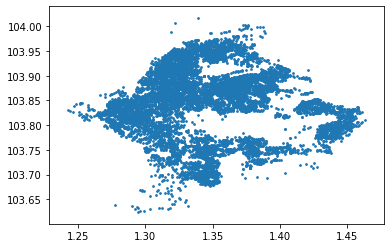

In [23]:
plt.scatter(
   ALL_AED['LatAED'], 
   ALL_AED['LongAED'],s=3
)

In [16]:
def totalCoverage(ohca_df, aed_df, MAX_DIST_METERS = 100):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000
    
    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 100, 'isCovered'] = 'covered'
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] > 100,'isCovered'] = 'uncovered'
    # each OHCA having an AED within 100m has isCovered = 'covered', otherwise 'uncovered'
    #print(cp_ohca)
    
    
    within_100m  = sum(cp_ohca['isCovered'] == 'covered')
    outside_100m = len(cp_ohca) - within_100m
    total_coverage_within_100m = within_100m / (within_100m + outside_100m)
    print("total coverage = ", total_coverage_within_100m)
    
    return total_coverage_within_100m

def partial_coverage(ohca_df, aed_df, ALPHA = 0.05):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 20,'p_ij_coverage'] = 1.0
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] >= 100,'p_ij_coverage'] = 0.0
    cp_ohca.loc[(cp_ohca['dist_nearest_AED'] < 100) & (cp_ohca['dist_nearest_AED'] > 20),
                'p_ij_coverage'] = np.exp(- ALPHA * (cp_ohca['dist_nearest_AED'] - 20))
    # p_ij of each OHCA calulated
    # print(cp_ohca)
    
    return cp_ohca['p_ij_coverage'].mean()

def expectedsurvival(OHCA,AED):
    prob = 0
    for i in range(len(OHCA)):
        survival = haversine_vector((OHCA.LatOHCA[i], OHCA.LongOHCA[i]), list(zip(AED.LatAED, AED.LongAED)), Unit.METERS, comb=True).T[0]
        survival = survival/(6.15*1000/60)*2
        survival = [p if np.isnan(p) == False else 0 for p in survival]
        survival = [1 if p<=1 and p != 0 else p for p in survival]
        survival = [p if p<20 else 0 for p in survival]
        survival = [p if p==0 or p == 1 else ((p**-0.584)*0.549) for p in survival]
        prob += max(survival)
    expectedSurvival = prob/len(OHCA)
    return(expectedSurvival)

In [22]:
AED_Chosen_All_PCM= ALL_AED.reset_index(drop=True)
#total coverage 
PCM_TC = totalCoverage(OHCA,AED_Chosen_All_PCM,100)
print("PCM total coverage is : ", PCM_TC)
#partial coverage
PCM_PC = partial_coverage(OHCA,AED_Chosen_All_PCM)
print("PCM partial coverage is : ", PCM_PC)
#expected survival
PCM_ES = expectedsurvival(OHCA,AED_Chosen_All_PCM)
print("PCM expected survival is : ", PCM_ES)


total coverage =  0.5716878030776802
PCM total coverage is :  0.5716878030776802
PCM partial coverage is :  0.23276695100315667
PCM expected survival is :  0.5327827868785249


In [21]:
#average distance to nearest AED
PCM_AD = average_distance(OHCA, AED_Chosen_All_PCM)
print("PCM average distance is : ", PCM_AD)

PCM average distance is :  164.47633066770322


In [18]:
def average_distance(ohca_df, aed_df):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    
    return cp_ohca['dist_nearest_AED'].mean()